### Objective: To download structures of antibodies from SAbDb. 

We want to compare the effects of using an experimentally solved structure versus a computational prediction with the AntibodyBuilder protien. 

We are getting the antibodies from SabDb. 


https://opig.stats.ox.ac.uk/webapps/sabdab-sabpred/sabdab/pdb/6r8x/?raw=true


#### Load modules

In [1]:
import pandas as pd
from biopandas.pdb import PandasPdb
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
from Bio.PDB.PDBIO import PDBIO, Select
from Bio.SeqUtils import seq1
from  pdbfixer import PDBFixer
from openmm.app import PDBFile
from pathlib import Path
import seaborn as sns
import numpy as np
import requests
from io import StringIO
from tqdm.notebook import tqdm 
import nglview as nv
from abnumber import Chain

import warnings
warnings.filterwarnings("ignore")

from developability.utils import ls, extract_sequence_from_pdb, determine_chain_type
from developability.descriptors import extract_sequence_from_residue_potential_df, chain_to_df, calculate_descriptors
from developability.pipeline import run_processing_pipeline

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
%config InlineBackend.figure_format='retina'

#### Get tables for antibodies on ThSAbDb and one that I calculated descriptors for. 

In [2]:
data_path = Path("/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies")

thab_df = pd.read_csv(data_path/'TSAbDb.csv')
thab_df = thab_df.rename({'Therapeutic': 'antibody'}, axis = 1)
thab_df['antibody'] =thab_df['antibody'].str.lower()

# clean up the entries. 
new_structure_map ={'100% SI Structure': 'structure100', '99% SI Structure':'structure99', '95-98% SI Structure': 'structure95'}
structure_columns = list(new_structure_map.values())
cols = ['antibody']+structure_columns

thab_df = thab_df.rename(new_structure_map, axis = 1)

# get only abs with structure. 
thabs_with_structure = (thab_df.replace('None;None', np.NaN)
                        .dropna(subset = structure_columns, how = 'all')
                        )

thabs_with_structure.head(10)[cols]

,antibody,structure100,structure99,structure95
1,abciximab,6v4p:CD,NaN,NaN
2,abelacimab,6r8x:CB,NaN,NaN
9,acimtamig,NaN,NaN,7seg:AB:HL;None
12,adalimumab,6cr1:HL/4nyl:AB:CD:EF:HL,3wd5:HL,NaN
15,adintrevimab,NaN,7u2d:HL,7u2e:HL
16,aducanumab,6cnr:HL/6co3:HL,NaN,NaN
17,afasevikumab,6ppg:HL:BA,NaN,NaN
19,alemtuzumab,1bey:HL/1ce1:HL,NaN,NaN
22,alomfilimab,7joo:HL,NaN,NaN
25,amatuximab,7ued:HL,4f33:BA:DC:FE:HG/4f3f:BA,NaN


#### Load info on antibodies that I computed on. 

In [3]:
renumbered_abs = data_path/'AbodyBuilder2_predicted_renumbered_stuctures'
desc_df = (pd.read_csv(renumbered_abs/'antibody_descriptor_results.csv').
           sort_values(['antibody'])
           )
desc_df.head()

,antibody,Heparin,FcRn,HCDR1_APBS_pos,HCDR1_APBS_neg,HCDR1_APBS_net,HCDR2_APBS_pos,HCDR2_APBS_neg,HCDR2_APBS_net,HCDR3_APBS_pos,HCDR3_APBS_neg,HCDR3_APBS_net,HFR1_APBS_pos,HFR1_APBS_neg,HFR1_APBS_net,HFR2_APBS_pos,HFR2_APBS_neg,HFR2_APBS_net,HFR3_APBS_pos,HFR3_APBS_neg,HFR3_APBS_net,HFR4_APBS_pos,HFR4_APBS_neg,HFR4_APBS_net,LCDR1_APBS_pos,LCDR1_APBS_neg,LCDR1_APBS_net,LCDR2_APBS_pos,LCDR2_APBS_neg,LCDR2_APBS_net,LCDR3_APBS_pos,LCDR3_APBS_neg,LCDR3_APBS_net,LFR1_APBS_pos,LFR1_APBS_neg,LFR1_APBS_net,LFR2_APBS_pos,LFR2_APBS_neg,LFR2_APBS_net,LFR3_APBS_pos,LFR3_APBS_neg,LFR3_APBS_net,LFR4_APBS_pos,LFR4_APBS_neg,LFR4_APBS_net,HCDR_APBS_pos,HCDR_APBS_neg,HCDR_APBS_net,LCDR_APBS_pos,LCDR_APBS_neg,LCDR_APBS_net,HFR_APBS_pos,HFR_APBS_neg,HFR_APBS_net,LFR_APBS_pos,LFR_APBS_neg,LFR_APBS_net,HC_APBS_pos,HC_APBS_neg,HC_APBS_net,LC_APBS_pos,LC_APBS_neg,LC_APBS_net,TOTAL_CDR_APBS_pos,TOTAL_CDR_APBS_neg,TOTAL_CDR_APBS_net,TOTAL_FR_APBS_pos,TOTAL_FR_APBS_neg,TOTAL_FR_APBS_net,TOTAL_APBS_pos,TOTAL_APBS_neg,TOTAL_APBS_net
18,abituzumab,0.60,0.32,1604.471203,0.000000,1604.471203,1940.449127,-5937.638320,-3997.189194,4429.654847,-225.665159,4203.989688,9554.111534,-1048.530514,8505.581021,0.000000,-3026.537762,-3026.537762,1402.789526,-3900.183829,-2497.394303,368.028702,-1443.379396,-1075.350694,1100.572916,-1383.729866,-283.156950,5747.028201,0.000000,5747.028201,7.025842,-1870.713811,-1863.687970,2415.742340,-2019.214098,396.528243,7342.511884,-3.560709,7338.951175,6316.524501,-776.591418,5539.933083,800.923443,-1776.160041,-975.236598,7974.575176,-6163.303479,1811.271697,6854.626959,-3254.443677,3600.183281,11324.929762,-9418.631501,1906.298261,16875.702169,-4575.526266,12300.175903,19299.504939,-15581.934981,3717.569958,23730.329128,-7829.969943,15900.359184,14829.202135,-9417.747157,5411.454979,28200.631931,-13994.157768,14206.474164,43029.834066,-23411.904924,19617.929142
60,abrilumab,0.51,-0.17,0.000000,-2753.935986,-2753.935986,938.671592,-16752.187679,-15813.516087,0.000000,-4053.727671,-4053.727671,1572.647590,-8831.550595,-7258.903005,2352.600018,-344.507378,2008.092640,1318.716922,-11239.613892,-9920.896970,316.989289,-1493.791779,-1176.802489,740.819193,-1782.163073,-1041.343880,48.766050,-2957.568655,-2908.802605,24.931413,-2810.490849,-2785.559436,1609.048873,-2440.177742,-831.128869,3480.885872,-592.089536,2888.796335,1052.447036,-3707.857774,-2655.410738,739.662721,-2360.694257,-1621.031536,938.671592,-23559.851336,-22621.179744,814.516656,-7550.222578,-6735.705921,5560.953820,-21909.463644,-16348.509824,6882.044502,-9100.819309,-2218.774807,6499.625412,-45469.314980,-38969.689568,7696.561158,-16651.041887,-8954.480729,1753.188248,-31110.073913,-29356.885665,12442.998322,-31010.282954,-18567.284632,14196.186570,-62120.356867,-47924.170297
0,adalimumab,0.79,1.04,361.422343,-794.503791,-433.081449,1555.624126,-4014.715450,-2459.091324,2875.086488,-138.003294,2737.083194,5376.458039,-1771.257720,3605.200319,2726.475633,-584.411432,2142.064200,3398.963679,-1368.871898,2030.091781,905.524940,-973.487817,-67.962877,7088.950311,-2.623292,7086.327019,1842.767512,0.000000,1842.767512,3232.607354,-34.553594,3198.053760,5204.403827,-935.352752,4269.051075,6533.142402,-21.319271,6511.823132,6140.552634,-104.698825,6035.853809,1542.070672,-1031.505891,510.564781,4792.132957,-4947.222536,-155.089579,12164.325177,-37.176886,12127.148291,12407.422291,-4698.028867,7709.393424,19420.169535,-2092.876739,17327.292796,17199.555248,-9645.251403,7554.303845,31584.494712,-2130.053625,29454.441087,16956.458134,-4984.399421,11972.058712,31827.591826,-6790.905606,25036.686220,48784.049960,-11775.305027,37008.744932
65,alemtuzumab,0.70,0.09,1532.439237,0.000000,1532.439237,14369.230068,0.000000,14369.230068,4886.091340,0.000000,4886.091340,17280.688445,-27.178419,17253.510027,5702.850968,0.000000,5702.850968,14492.146977,0.000000,14492.146977,2177.378996,-44.267878,2133.111118,5843.170300,0.000000,5843.170300,3963.939783,0.000000,3963.939783,5702.305471,0.0

#### Parse into long format. 
Below I parse the data above. 

In [4]:
therapeutic_abs_long =[]
struct_cols = ['structure100', 'structure99', 'structure95']

for _,row in thabs_with_structure.iterrows():
    antibody = row.antibody
    for col in struct_cols:
          try: 
              if row[col]: 
                  for pdb_entry in row[col].split('/'):
                       pdb_code, chains = pdb_entry.split(':') 
                       therapeutic_abs_long.append((antibody, pdb_code.replace('None;',''), chains, col.replace('structure', '') ))
          except:
               pass
        
therapeutic_abs_long=pd.DataFrame(therapeutic_abs_long, columns= ['antibody', 'pdb_code', 'Fab', '%'])
therapeutic_abs_long['%'] = therapeutic_abs_long['%'].astype(int)
therapeutic_abs_long = therapeutic_abs_long.sort_values(['antibody','%'], ascending = [True, False] )
therapeutic_abs_long.head()


,antibody,pdb_code,Fab,%
0,abciximab,6v4p,CD,100
1,abelacimab,6r8x,CB,100
2,adalimumab,6cr1,HL,100
3,adalimumab,3wd5,HL,99
4,adintrevimab,7u2d,HL,99


#### Functions 

In [5]:
def download_therapeutic_ab_pdb(code, name, output_dir=None):

    if not output_dir: 
        output_dir = Path().cwd()

    url = f'https://opig.stats.ox.ac.uk/webapps/sabdab-sabpred/sabdab/pdb/{code}/?raw=true'
    
    file = Path(output_dir)/f'{code}_{name}.pdb'
    file.write_text(requests.get(url).text)

def download_pdb(pdb_id, protein_name='',output_path=None, pdb=None, atoms_only=False): 
    """Uses BioPandas to download pdb"""
    if not pdb: 
        pdb= PandasPdb()
    p = pdb.fetch_pdb(pdb_id)

    if not output_path: 
        output_path = Path().cwd()
    
    if atoms_only:
        p.to_pdb(output_path/f'{protein_name}_{pdb_id}.pdb', records =['ATOM'])
    else:
        p.to_pdb(output_path/f'{protein_name}_{pdb_id}.pdb')
    

def parse_structure_string(string): 
    
    pdbs = string.split('/')
    for pdb in pdbs: 
        yield(pdb.split(':')[0])

def get_summary(pdb_code, name):
    """gets summary from ThSAbDb for a pdb_code"""
    url = f'https://opig.stats.ox.ac.uk/webapps/sabdab-sabpred/sabdab/summary/{pdb_code}/'
    text=requests.get(url).text
    summary = pd.read_csv(StringIO(text), sep='\t')
    summary.insert(0, 'antibody', name)
    return summary


def show_struct(pdb_file, size = 500, gui = False): 
    print(pdb_file.name)
    view = nv.show_structure_file(str(pdb_file))
    view._remote_call('setSize', target='Widget', args=['',f'{size}px'])
    view.render_image(factor = 2)
    view.display(gui)
    return view
    

class ChainSelect(Select): 
    def __init__(self, chain_ids):
        """Select for getting specific chains

        Args:
            chain_ids (list[str]): list of chain ids
        """
        self.chain_ids = chain_ids

    def accept_chain(self, chain): 
        if chain.get_id() in self.chain_ids: 
            return True
        else: 
            return False


def save_pdb_with_select_chains(input_pdb, chains, output_path=None): 
    """Saves pdbs as new file with select chains only
    Args:
        input_pdb (Path|str): Path to the input_pdb
        chains (list[str]): list of names for chain
        output_path (Path|str, optional): Output path. Defaults to None.
    Returns:
        None
    """
    input_pdb = Path(input_pdb)
    name = input_pdb.name.split('.')[0]
    output_name = f'{name}_{"".join(chains)}.pdb'

    if not output_path: 
        output_path = input_pdb.parent
        
    parser = PDBParser()
    struct= parser.get_structure(name, str(input_pdb))
    
    io = PDBIO()
    io.set_structure(struct)
    io.save(str(output_path/output_name),ChainSelect(chains))


def remove_chains(fixer, chains_to_keep): 
    """Uses fixer.remove_chains to remove chains not present in chain_to_keep. Keeps the first occurence of each chain. 

    Args:
        fixer (pdbfixer.pdbfixer.PDBFixer): fixer object for fixing pdbs. 
        chains_to_keep (list[str]): list of chain ids to keep, all others removed
    Returns: 
        None
    """
    seen = set()
    indices_to_remove = []
    for i, chain in enumerate(fixer.topology.chains()):
        if chain.id not in seen and chain.id in chains_to_keep: 
            seen.add(chain.id)
        else:
            indices_to_remove.append(i) 

    fixer.removeChains(indices_to_remove)   
    return fixer


def fix_antibody(antibody_file, chains_to_keep=[], output_path=None, keep_ids=False, fix_internal_residues_only=True): 
    """Uses PDB fixer to fix antibody
    Args: 
        antibody_file(str|Path): file path
        chains_to_keep(list[str]): list of Fab chains to keep
    Returns: 
        None
    """
    fixer = PDBFixer(str(antibody_file))

    if chains_to_keep: 
        remove_chains(fixer, chains_to_keep)
    fixer.findMissingResidues()

    if fix_internal_residues_only: 
        chains = list(fixer.topology.chains())
        keys = fixer.missingResidues.keys()
        keys_to_remove = []
        for key in keys:
            chain = chains[key[0]]
            if key[1] == 0 or key[1] == len(list(chain.residues())):
                keys_to_remove.append(key)

        for key in keys_to_remove: 
            del fixer.missingResidues[key]

    fixer.findNonstandardResidues()
    fixer.replaceNonstandardResidues()
    fixer.removeHeterogens(False)
    fixer.findMissingAtoms()
    fixer.addMissingAtoms()

    # save
    if not output_path: 
        output_path = antibody_file.parent

    output = str(output_path /antibody_file.name)
    PDBFile.writeFile(fixer.topology, fixer.positions, open(output, 'w'), keepIds = keep_ids)
    return fixer

#### Download the antibodies

In [6]:
output_path = data_path/'solved_therapeutic_abs'
if not output_path.exists(): 
    output_path.mkdir()
    
pdb = PandasPdb()
proteins = []
pdb_ids = []

if not output_path.exists():

    failed_sequences = []
    for _,row in thabs_with_structure.iterrows():
        protein = row.antibody
        for string in [row.structure100, row.structure99, row.structure95 ]:
            if isinstance(string, str):
                for pdb_id in parse_structure_string(string):
                    pdb_id = pdb_id.replace('None;','')
                    fname = output_path/f'{protein}_{pdb_id}.pdb'
                    if not fname.exists():
                        try:
                            download_pdb(pdb_id, protein, output_path )
                            proteins.append(protein)
                            pdb_ids.append(pdb_id)
                        except:
                            failed_sequences.append(f'{protein}_{pdb_id}')

#### Download summaries. 

In [7]:
summary_file = data_path/'ab_summaries.csv'
if not summary_file.exists(): 

    summaries = []
    for _,row in thabs_with_structure.iterrows():
        protein = row.antibody
        for string in [row.structure100, row.structure99, row.structure95_98 ]:
            if isinstance(string, str):
                for pdb_id in parse_structure_string(string):
                    pdb_id = pdb_id.replace('None;','')
                    try:
                            summaries.append(get_summary(pdb_id, protein))
                    except:
                        pass

    sum_df = pd.concat(summaries)
    sum_df = sum_df.rename({'ab': 'antibody'}, axis=1)
    sum_df.to_csv(data_path/'ab_summaries.csv', index = False)
else:
    sum_df = pd.read_csv(summary_file) 
                        

In [8]:
# select xray-crystalls only
print(f'Total number pdbs is {len(sum_df)}')
sum_df = sum_df.query('method=="X-RAY DIFFRACTION"')
# dedupe based on pdb
sum_df = sum_df.drop_duplicates(subset = ['pdb'])
print(f'Number of unique pdbs for x-ray diffraction is {len(sum_df)}')


Total number pdbs is 2146
Number of unique pdbs for x-ray diffraction is 462


#### Plot the resolution and r factors

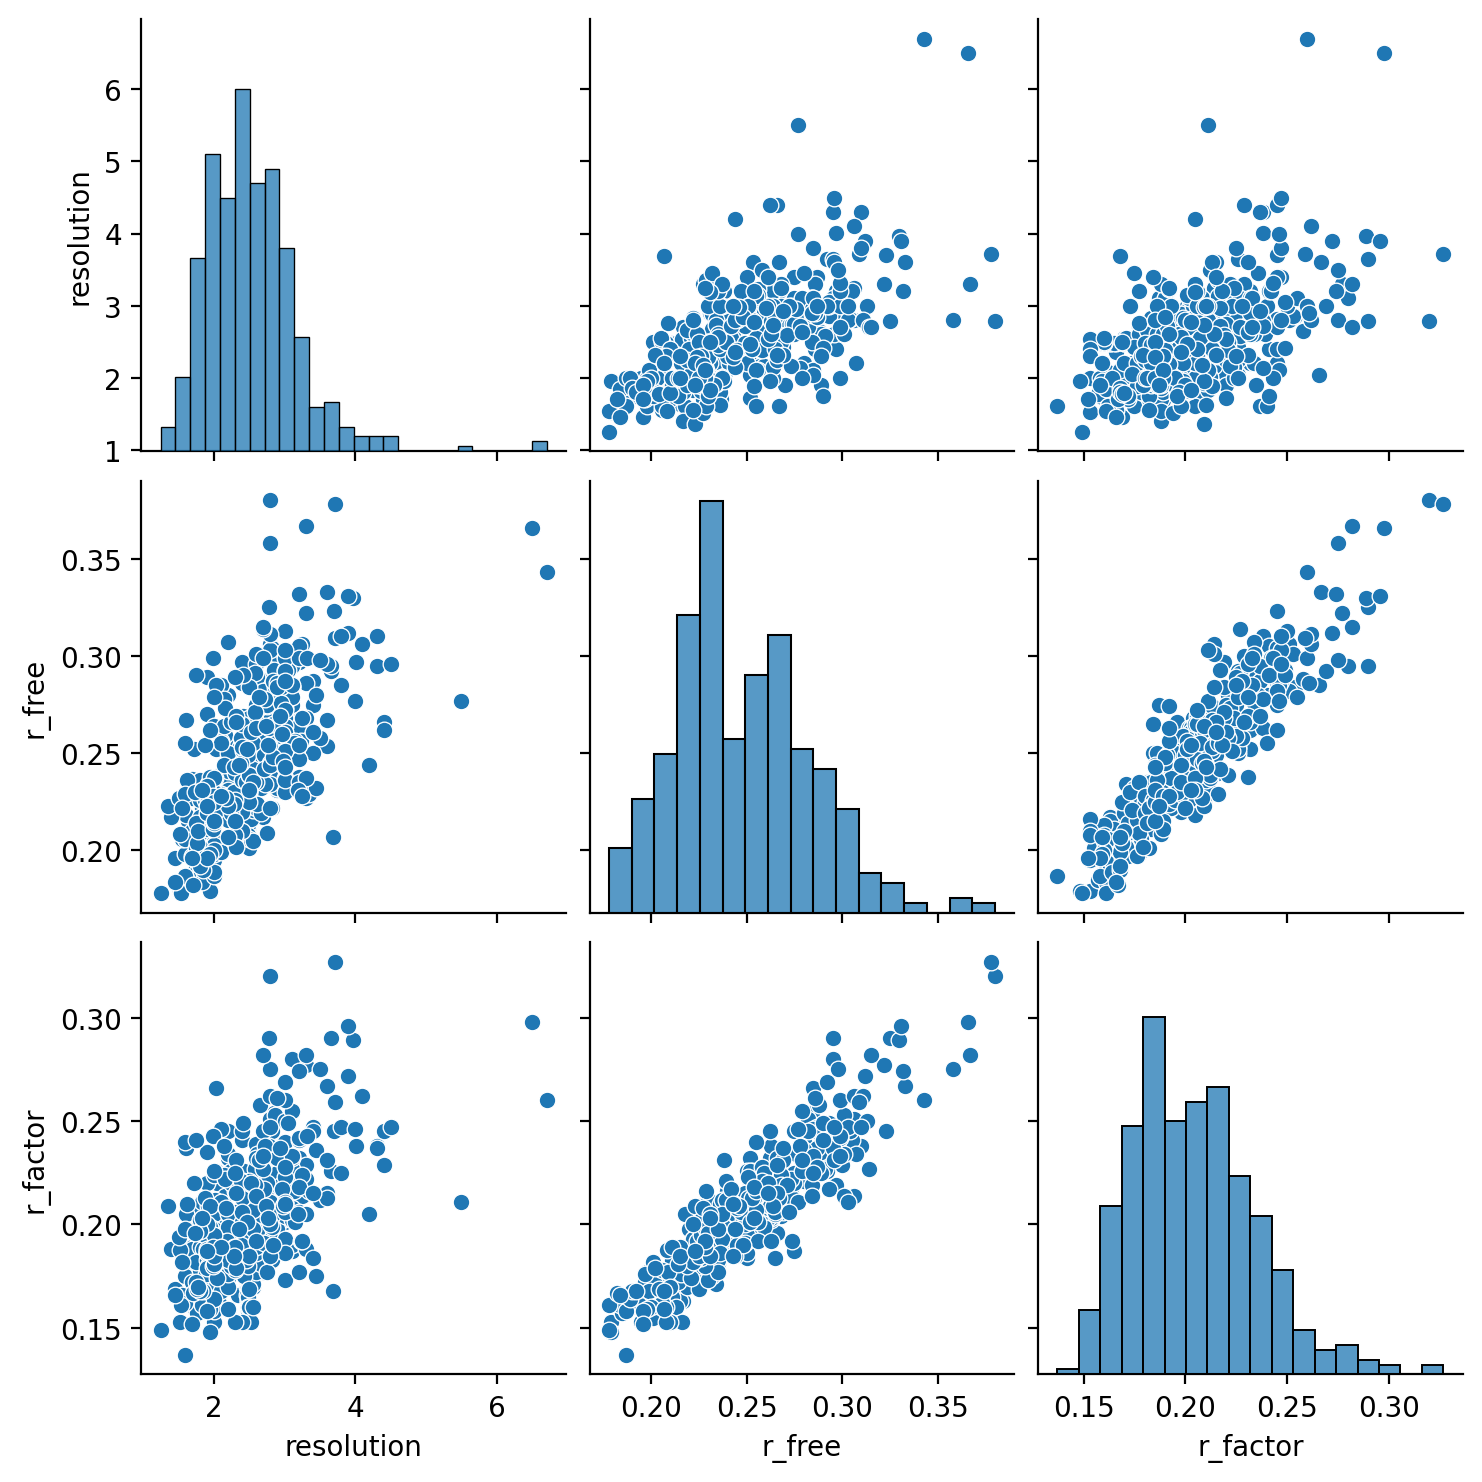

In [9]:
sum_df_subset = (sum_df[['resolution','r_free', 'r_factor']]
                 .replace('unknown', np.NAN)
                 .dropna()
                 .astype(float)
                 .copy())
sns.pairplot(sum_df_subset);

#### Order by antibody and resolution and then drop duplicate antibodies. 

In [10]:
sum_df = (sum_df.sort_values(['antibody', 'resolution'])
          .drop_duplicates(subset ='antibody')
          )
len(sum_df)

print(f'Number of pdbs of unique antibodies for x-ray diffraction is {len(sum_df)}.')

Number of pdbs of unique antibodies for x-ray diffraction is 204.


#### Save PDBs with only a single  Heavy and light chain for the 204 antibodies

I saved the chains of interest.

```python
fab_path = data_path/'HeavyLightChainAbPdbs'
if not fab_path.exists(): 
    fab_path.mkdir()

failed_abs = []
successful_abs = []

for _,row in tqdm(sum_df.iterrows(), total =len(sum_df)): 
    filename = f'{row.antibody}_{row.pdb}.pdb'
    input_pdb = output_path/filename
    if (input_pdb).exists(): 
        try: 
            chains_to_keep = [row['Hchain'],	row['Lchain']]
            print(row.antibody,chains_to_keep)
            fix_antibody(input_pdb,chains_to_keep,  output_path=fab_path, keep_ids=True)
            successful_abs.append(row.antibody)
        except: 
            failed_abs.append(row.antibody)
```

### Look at some of these strucutres and compare to sequence. 

In [11]:
thabs_df = thabs_with_structure[['antibody','Format', 'Heavy Sequence', 'Light Sequence']].merge(sum_df,on='antibody')
thabs_df.head(1)

,antibody,Format,Heavy Sequence,Light Sequence,pdb,Hchain,Lchain,model,antigen_chain,antigen_type,antigen_het_name,antigen_name,short_header,date,compound,organism,heavy_species,light_species,antigen_species,authors,resolution,method,r_free,r_factor,scfv,engineered,heavy_subclass,light_subclass,light_ctype,affinity,delta_g,affinity_method,temperature,pmid,<!doctype html>
0,abelacimab,Whole mAb,QVQLLESGGGLVQPGGSLRLSCAASGFTFSTAAMSWVRQAPGKGLE...,QSVLTQPPSASGTPGQRVTISCSGSSSNIGSNDVSWYQQLPGTAPK...,6r8x,C,B,0.0,A,protein,NaN,coagulation factor xi,BLOOD CLOTTING,04/02/19,COAGULATION FACTOR XI CATALYTIC DOMAIN IN COMP...,HOMO SAPIENS; UNIDENTIFIED,unidentified,unidentified,homo sapiens,"Schiering, N., Koch, A.",2.04,X-RAY DIFFRACTION,0.282,0.22,False,True,IGHV3,IGLV1,Lambda,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
fab_path = data_path/'HeavyLightChainAbPdbs'
fixed_files = [f for f in ls(fab_path) if f.suffix=='.pdb']
fixed_files.sort()

f = fixed_files[1]
show_struct(f)

acimtamig_7seg.pdb


NGLWidget()

#### Calculate the scores of interest. 

In [13]:
base_output_path = data_path/'solved_protein_electrostatics'
descriptors = []
if not base_output_path.exists(): 
    base_output_path.mkdir()

descriptors_pq = base_output_path/'solved_structure_descriptors.pq'
if not descriptors_pq.exists():
#if True:
    for input_pdb in tqdm(fixed_files, total = len(fixed_files)):
        name = input_pdb.name.split('_')[0]
        output_path = base_output_path/ f'{name}_output'
        try: 
            if not output_path.exists(): 
                output_path.mkdir()
                desc_df = run_processing_pipeline(input_pdb=input_pdb, output_path=output_path)
                desc_df.index = [name]
            descriptors.append(desc_df)
        except:
            pass

    descriptors_df = pd.concat(descriptors)
    descriptors_df.to_parquet(descriptors_pq )
else:
    descriptors_df = pd.read_parquet(descriptors_pq)

    


#### Reannotate the residual potential df and save the file. 

In [14]:
def find_substring_positions(s, t): 
    assert s.find(t) != -1, f'{t} not in {s}'

    start = s.find(t) + 1
    end = start + len(t) - 1
    return start, end


def annotate_fv_regions(pdb, residue_pot_df, scheme = 'kabat'):
    """Args: 
        sequences (dict): dictionary of the sequences of the antibody
        residue_pot_df (pd.DataFrame): dataframe with the residue potential
        scheme (str): antibody numbering scheme
    Returns:
        residue_pot_df (pd.DataFrame): dataframe with the residue potential annotated with the FV regions
    """

    target_sequence = extract_sequence_from_residue_potential_df(residue_pot_df)
    seqs = extract_sequence_from_pdb(pdb)
    light_chain_seq, heavy_chain_seq = determine_chain_type(seqs)

    light_chain = Chain(light_chain_seq, scheme=scheme)
    
    light_regions = chain_to_df(light_chain)
    
    start, end = find_substring_positions(target_sequence, light_chain.seq)
    light_regions['Residue_number'] = range(start, end+1)
    
    heavy_chain = Chain(heavy_chain_seq, scheme=scheme)
    heavy_regions = chain_to_df(heavy_chain)
    start, end = find_substring_positions(target_sequence, heavy_chain.seq)
    heavy_regions['Residue_number'] = range(start, end+1)

    ### reupdate numbers
    regions = pd.concat([light_regions, heavy_regions]).reset_index(drop=True)
    
    residue_pot_df['Residue'] = list(target_sequence)
    df = (residue_pot_df
          .fillna(0)
          .merge(regions, on = ['Residue_number', 'Residue'], how = 'left')
          .fillna('NonFV')
          .drop('Unnamed: 0',axis = 1)
          .rename({'Region': 'FV_region', 'Chain': 'FV_chain'}, axis = 1)
          )
    df['Chain_Region'] = df['FV_chain'] +'_'+ df['FV_region']
    
    return df

In [15]:
directories = [d for d in ls(base_output_path) if d.is_dir()]
names = [d.name.split('_')[0] for d in directories]
residue_potential_files = [d/'residue_potential.csv' for d in directories]
pdbs = [f for d in directories for  f in  ls(d) if f.name =='pdb4amber.pdb']

In [16]:
descriptors = []
n = len(names)
new_descriptors_path = data_path/'solved_structure_descriptors_11-07-23.csv'
if not new_descriptors_path.exists():

   for i in tqdm(range(n), total = n): 
      try: 
         residue_pot_df = pd.read_csv(residue_potential_files[i])
         pdb = pdbs[i]
         antibody_name = names[i]
      
         annotated_residue_pot_df= annotate_fv_regions(pdb, residue_pot_df)
         annotated_residue_pot_df.to_csv(residue_potential_files[i].with_suffix('.annotated.csv'))
         
         descriptors.append(calculate_descriptors(annotated_residue_pot_df, antibody_name))
         print(antibody_name)
         descriptors_df = pd.concat(descriptors)
         
         descriptors_df.to_parquet(new_descriptors_path)
         
      except:
         pass
else: 
      descriptors_df = pd.read_parquet(new_descriptors_path)


In [35]:
new_descriptors_path

PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/solved_structure_descriptors_11-07-23.csv')

In [17]:
descriptors_df.head()

,HCDR1_APBS_pos,HCDR1_APBS_neg,HCDR1_APBS_net,HCDR2_APBS_pos,HCDR2_APBS_neg,HCDR2_APBS_net,HCDR3_APBS_pos,HCDR3_APBS_neg,HCDR3_APBS_net,HFR1_APBS_pos,HFR1_APBS_neg,HFR1_APBS_net,HFR2_APBS_pos,HFR2_APBS_neg,HFR2_APBS_net,HFR3_APBS_pos,HFR3_APBS_neg,HFR3_APBS_net,HFR4_APBS_pos,HFR4_APBS_neg,HFR4_APBS_net,LCDR1_APBS_pos,LCDR1_APBS_neg,LCDR1_APBS_net,LCDR2_APBS_pos,LCDR2_APBS_neg,LCDR2_APBS_net,LCDR3_APBS_pos,LCDR3_APBS_neg,LCDR3_APBS_net,LFR1_APBS_pos,LFR1_APBS_neg,LFR1_APBS_net,LFR2_APBS_pos,LFR2_APBS_neg,LFR2_APBS_net,LFR3_APBS_pos,LFR3_APBS_neg,LFR3_APBS_net,LFR4_APBS_pos,LFR4_APBS_neg,LFR4_APBS_net,HCDR_APBS_pos,HCDR_APBS_neg,HCDR_APBS_net,LCDR_APBS_pos,LCDR_APBS_neg,LCDR_APBS_net,HFR_APBS_pos,HFR_APBS_neg,HFR_APBS_net,LFR_APBS_pos,LFR_APBS_neg,LFR_APBS_net,HC_APBS_pos,HC_APBS_neg,HC_APBS_net,LC_APBS_pos,LC_APBS_neg,LC_APBS_net,TOTAL_CDR_APBS_pos,TOTAL_CDR_APBS_neg,TOTAL_CDR_APBS_net,TOTAL_FR_APBS_pos,TOTAL_FR_APBS_neg,TOTAL_FR_APBS_net,TOTAL_APBS_pos,TOTAL_APBS_neg,TOTAL_APBS_net
gevokizumab,2230.443364,0.000000,2230.443364,4341.252688,-4381.641807,-40.389118,5310.451472,-945.332963,4365.118509,21849.292909,-58.602934,21790.689975,4098.378375,-52.642334,4045.736041,15877.805187,-150.138907,15727.666280,3620.359354,-33.854088,3586.505266,3792.722846,0.000000,3792.722846,6423.721200,0.000000,6423.721200,1848.514477,-187.707228,1660.807248,8781.153937,-354.215180,8426.938757,13959.088680,0.000000,13959.088680,12031.381982,-55.268056,11976.113926,3560.988331,-424.199424,3136.788907,11882.147525,-5326.974769,6555.172756,12064.958522,-187.707228,11877.251293,45445.835825,-295.238263,45150.597562,38332.612930,-833.682660,37498.930270,57327.983350,-5622.213032,51705.770318,50397.571452,-1021.389888,49376.181564,23947.106047,-5514.681998,18432.424049,83778.448755,-1128.920922,82649.527833,107725.554802,-6643.602920,101081.951882
navivumab,1684.456357,0.000000,1684.456357,9323.766766,-80.277346,9243.489420,16912.233006,0.000000,16912.233006,22658.900051,-121.801093,22537.098958,3312.258724,0.000000,3312.258724,13852.829294,-847.798663,13005.030630,4244.931642,-0.956827,4243.974814,12385.982657,0.000000,12385.982657,6418.063727,0.000000,6418.063727,4107.631973,0.000000,4107.631973,11965.786550,-248.462964,11717.323585,12830.043168,0.000000,12830.043168,16352.481149,-861.745297,15490.735852,5191.517023,-142.026950,5049.490073,27920.456129,-80.277346,27840.178782,22911.678358,0.000000,22911.678358,44068.919710,-970.556584,43098.363126,46339.827890,-1252.235211,45087.592679,71989.375839,-1050.833931,70938.541909,69251.506248,-1252.235211,67999.271037,50832.134487,-80.277346,50751.857140,90408.747600,-2222.791796,88185.955805,141240.882087,-2303.069142,138937.812945
guselkumab,2614.602218,0.000000,2614.602218,10815.748375,-179.209381,10636.538995,7531.720864,0.000000,7531.720864,16153.073936,-523.931600,15629.142335,4859.412572,-105.606372,4753.806200,14991.525327,-20.598328,14970.926999,1987.006845,-61.550649,1925.456195,4594.698447,-70.167138,4524.531308,8910.313107,0.000000,8910.313107,5816.911834,-133.722479,5683.189355,16881.952947,0.000000,16881.952947,3489.892831,-216.543316,3273.349516,11867.522685,-1815.572619,10051.950066,2765.719670,-28.851959,2736.867710,20962.071458,-179.209381,20782.862077,19321.923388,-203.889617,19118.033771,37991.018680,-711.686950,37279.331730,35005.088133,-2060.967894,32944.120239,58953.090138,-890.896331,58062.193807,54327.011520,-2264.857511,52062.154010,40283.994846,-383.098998,39900.895848,72996.106813,-2772.654844,70223.451969,113280.101658,-3155.753842,110124.347817
lebrikizumab,1135.120249,0.000000,1135.120249,13492.202761,0.000000,13492.202761,4890.920459,-189.017909,4701.902551,30764.480330,0.000000,30764.480330,4418.116020,0.000000,4418.116020,18993.061409,0.000000,18993.061409,5806.794129,0.000000,5806.794129,14708.944039,0.000000,14708.944039,1081.275804,-353.398106,727.877698,4057.764643,0.000000,4057.764643,6748.924434,-1697.407944,5051.516489,7999.367831,0.000000,7999.367831,7654.356380,-8

### Load the previous results and compare. 

In [18]:

previous_results = pd.read_csv(renumbered_abs/'antibody_descriptor_results.csv')
previous_results = previous_results.set_index('antibody').sort_index()

previous_results.head()

,Heparin,FcRn,HCDR1_APBS_pos,HCDR1_APBS_neg,HCDR1_APBS_net,HCDR2_APBS_pos,HCDR2_APBS_neg,HCDR2_APBS_net,HCDR3_APBS_pos,HCDR3_APBS_neg,HCDR3_APBS_net,HFR1_APBS_pos,HFR1_APBS_neg,HFR1_APBS_net,HFR2_APBS_pos,HFR2_APBS_neg,HFR2_APBS_net,HFR3_APBS_pos,HFR3_APBS_neg,HFR3_APBS_net,HFR4_APBS_pos,HFR4_APBS_neg,HFR4_APBS_net,LCDR1_APBS_pos,LCDR1_APBS_neg,LCDR1_APBS_net,LCDR2_APBS_pos,LCDR2_APBS_neg,LCDR2_APBS_net,LCDR3_APBS_pos,LCDR3_APBS_neg,LCDR3_APBS_net,LFR1_APBS_pos,LFR1_APBS_neg,LFR1_APBS_net,LFR2_APBS_pos,LFR2_APBS_neg,LFR2_APBS_net,LFR3_APBS_pos,LFR3_APBS_neg,LFR3_APBS_net,LFR4_APBS_pos,LFR4_APBS_neg,LFR4_APBS_net,HCDR_APBS_pos,HCDR_APBS_neg,HCDR_APBS_net,LCDR_APBS_pos,LCDR_APBS_neg,LCDR_APBS_net,HFR_APBS_pos,HFR_APBS_neg,HFR_APBS_net,LFR_APBS_pos,LFR_APBS_neg,LFR_APBS_net,HC_APBS_pos,HC_APBS_neg,HC_APBS_net,LC_APBS_pos,LC_APBS_neg,LC_APBS_net,TOTAL_CDR_APBS_pos,TOTAL_CDR_APBS_neg,TOTAL_CDR_APBS_net,TOTAL_FR_APBS_pos,TOTAL_FR_APBS_neg,TOTAL_FR_APBS_net,TOTAL_APBS_pos,TOTAL_APBS_neg,TOTAL_APBS_net
antibody,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
abituzumab,0.60,0.32,1604.471203,0.000000,1604.471203,1940.449127,-5937.638320,-3997.189194,4429.654847,-225.665159,4203.989688,9554.111534,-1048.530514,8505.581021,0.000000,-3026.537762,-3026.537762,1402.789526,-3900.183829,-2497.394303,368.028702,-1443.379396,-1075.350694,1100.572916,-1383.729866,-283.156950,5747.028201,0.000000,5747.028201,7.025842,-1870.713811,-1863.687970,2415.742340,-2019.214098,396.528243,7342.511884,-3.560709,7338.951175,6316.524501,-776.591418,5539.933083,800.923443,-1776.160041,-975.236598,7974.575176,-6163.303479,1811.271697,6854.626959,-3254.443677,3600.183281,11324.929762,-9418.631501,1906.298261,16875.702169,-4575.526266,12300.175903,19299.504939,-15581.934981,3717.569958,23730.329128,-7829.969943,15900.359184,14829.202135,-9417.747157,5411.454979,28200.631931,-13994.157768,14206.474164,43029.834066,-23411.904924,19617.929142
abrilumab,0.51,-0.17,0.000000,-2753.935986,-2753.935986,938.671592,-16752.187679,-15813.516087,0.000000,-4053.727671,-4053.727671,1572.647590,-8831.550595,-7258.903005,2352.600018,-344.507378,2008.092640,1318.716922,-11239.613892,-9920.896970,316.989289,-1493.791779,-1176.802489,740.819193,-1782.163073,-1041.343880,48.766050,-2957.568655,-2908.802605,24.931413,-2810.490849,-2785.559436,1609.048873,-2440.177742,-831.128869,3480.885872,-592.089536,2888.796335,1052.447036,-3707.857774,-2655.410738,739.662721,-2360.694257,-1621.031536,938.671592,-23559.851336,-22621.179744,814.516656,-7550.222578,-6735.705921,5560.953820,-21909.463644,-16348.509824,6882.044502,-9100.819309,-2218.774807,6499.625412,-45469.314980,-38969.689568,7696.561158,-16651.041887,-8954.480729,1753.188248,-31110.073913,-29356.885665,12442.998322,-31010.282954,-18567.284632,14196.186570,-62120.356867,-47924.170297
adalimumab,0.79,1.04,361.422343,-794.503791,-433.081449,1555.624126,-4014.715450,-2459.091324,2875.086488,-138.003294,2737.083194,5376.458039,-1771.257720,3605.200319,2726.475633,-584.411432,2142.064200,3398.963679,-1368.871898,2030.091781,905.524940,-973.487817,-67.962877,7088.950311,-2.623292,7086.327019,1842.767512,0.000000,1842.767512,3232.607354,-34.553594,3198.053760,5204.403827,-935.352752,4269.051075,6533.142402,-21.319271,6511.823132,6140.552634,-104.698825,6035.853809,1542.070672,-1031.505891,510.564781,4792.132957,-4947.222536,-155.089579,12164.325177,-37.176886,12127.148291,12407.422291,-4698.028867,7709.393424,19420.169535,-2092.876739,17327.292796,17199.555248,-9645.251403,7554.303845,31584.494712,-2130.053625,29454.441087,16956.458134,-4984.399421,11972.058712,31827.591826,-6790.905606,25036.686220,48784.049960,-11775.305027,37008.744932
alemtuzumab,0.70,0.09,1532.439237,0.000000,1532.439237,14369.230068,0.000000,14369.230068,4886.091340,0.000000,4886.091340,17280.688445,-27.178419,17253.510027,5702.850968,0.000000,5702.850968,14492.146977,0.000000,14492.146977,2177.378996,-44.267878,2133.111118,5843.170300,0.000000,

In [19]:
# get the rows that we have previous results for. 
subset_df = (descriptors_df.loc[descriptors_df.index.isin(previous_results.index)]
             .sort_index()
             )
previous_subset_df = (previous_results.loc[previous_results.index.isin(subset_df.index)]
                      .copy()
                      .sort_index()
                      )

In [20]:
previous_results.head()

,Heparin,FcRn,HCDR1_APBS_pos,HCDR1_APBS_neg,HCDR1_APBS_net,HCDR2_APBS_pos,HCDR2_APBS_neg,HCDR2_APBS_net,HCDR3_APBS_pos,HCDR3_APBS_neg,HCDR3_APBS_net,HFR1_APBS_pos,HFR1_APBS_neg,HFR1_APBS_net,HFR2_APBS_pos,HFR2_APBS_neg,HFR2_APBS_net,HFR3_APBS_pos,HFR3_APBS_neg,HFR3_APBS_net,HFR4_APBS_pos,HFR4_APBS_neg,HFR4_APBS_net,LCDR1_APBS_pos,LCDR1_APBS_neg,LCDR1_APBS_net,LCDR2_APBS_pos,LCDR2_APBS_neg,LCDR2_APBS_net,LCDR3_APBS_pos,LCDR3_APBS_neg,LCDR3_APBS_net,LFR1_APBS_pos,LFR1_APBS_neg,LFR1_APBS_net,LFR2_APBS_pos,LFR2_APBS_neg,LFR2_APBS_net,LFR3_APBS_pos,LFR3_APBS_neg,LFR3_APBS_net,LFR4_APBS_pos,LFR4_APBS_neg,LFR4_APBS_net,HCDR_APBS_pos,HCDR_APBS_neg,HCDR_APBS_net,LCDR_APBS_pos,LCDR_APBS_neg,LCDR_APBS_net,HFR_APBS_pos,HFR_APBS_neg,HFR_APBS_net,LFR_APBS_pos,LFR_APBS_neg,LFR_APBS_net,HC_APBS_pos,HC_APBS_neg,HC_APBS_net,LC_APBS_pos,LC_APBS_neg,LC_APBS_net,TOTAL_CDR_APBS_pos,TOTAL_CDR_APBS_neg,TOTAL_CDR_APBS_net,TOTAL_FR_APBS_pos,TOTAL_FR_APBS_neg,TOTAL_FR_APBS_net,TOTAL_APBS_pos,TOTAL_APBS_neg,TOTAL_APBS_net
antibody,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
abituzumab,0.60,0.32,1604.471203,0.000000,1604.471203,1940.449127,-5937.638320,-3997.189194,4429.654847,-225.665159,4203.989688,9554.111534,-1048.530514,8505.581021,0.000000,-3026.537762,-3026.537762,1402.789526,-3900.183829,-2497.394303,368.028702,-1443.379396,-1075.350694,1100.572916,-1383.729866,-283.156950,5747.028201,0.000000,5747.028201,7.025842,-1870.713811,-1863.687970,2415.742340,-2019.214098,396.528243,7342.511884,-3.560709,7338.951175,6316.524501,-776.591418,5539.933083,800.923443,-1776.160041,-975.236598,7974.575176,-6163.303479,1811.271697,6854.626959,-3254.443677,3600.183281,11324.929762,-9418.631501,1906.298261,16875.702169,-4575.526266,12300.175903,19299.504939,-15581.934981,3717.569958,23730.329128,-7829.969943,15900.359184,14829.202135,-9417.747157,5411.454979,28200.631931,-13994.157768,14206.474164,43029.834066,-23411.904924,19617.929142
abrilumab,0.51,-0.17,0.000000,-2753.935986,-2753.935986,938.671592,-16752.187679,-15813.516087,0.000000,-4053.727671,-4053.727671,1572.647590,-8831.550595,-7258.903005,2352.600018,-344.507378,2008.092640,1318.716922,-11239.613892,-9920.896970,316.989289,-1493.791779,-1176.802489,740.819193,-1782.163073,-1041.343880,48.766050,-2957.568655,-2908.802605,24.931413,-2810.490849,-2785.559436,1609.048873,-2440.177742,-831.128869,3480.885872,-592.089536,2888.796335,1052.447036,-3707.857774,-2655.410738,739.662721,-2360.694257,-1621.031536,938.671592,-23559.851336,-22621.179744,814.516656,-7550.222578,-6735.705921,5560.953820,-21909.463644,-16348.509824,6882.044502,-9100.819309,-2218.774807,6499.625412,-45469.314980,-38969.689568,7696.561158,-16651.041887,-8954.480729,1753.188248,-31110.073913,-29356.885665,12442.998322,-31010.282954,-18567.284632,14196.186570,-62120.356867,-47924.170297
adalimumab,0.79,1.04,361.422343,-794.503791,-433.081449,1555.624126,-4014.715450,-2459.091324,2875.086488,-138.003294,2737.083194,5376.458039,-1771.257720,3605.200319,2726.475633,-584.411432,2142.064200,3398.963679,-1368.871898,2030.091781,905.524940,-973.487817,-67.962877,7088.950311,-2.623292,7086.327019,1842.767512,0.000000,1842.767512,3232.607354,-34.553594,3198.053760,5204.403827,-935.352752,4269.051075,6533.142402,-21.319271,6511.823132,6140.552634,-104.698825,6035.853809,1542.070672,-1031.505891,510.564781,4792.132957,-4947.222536,-155.089579,12164.325177,-37.176886,12127.148291,12407.422291,-4698.028867,7709.393424,19420.169535,-2092.876739,17327.292796,17199.555248,-9645.251403,7554.303845,31584.494712,-2130.053625,29454.441087,16956.458134,-4984.399421,11972.058712,31827.591826,-6790.905606,25036.686220,48784.049960,-11775.305027,37008.744932
alemtuzumab,0.70,0.09,1532.439237,0.000000,1532.439237,14369.230068,0.000000,14369.230068,4886.091340,0.000000,4886.091340,17280.688445,-27.178419,17253.510027,5702.850968,0.000000,5702.850968,14492.146977,0.000000,14492.146977,2177.378996,-44.267878,2133.111118,5843.170300,0.000000,

In [21]:
# remove columns with lots of zeros in both
subset_zero = (subset_df==0).mean()
prev_subset_zero = (previous_subset_df==0).mean()

remove_cols = [col for col in subset_zero.index if subset_zero.loc[col]>=1]
remove_cols.extend([col for col in prev_subset_zero.index if prev_subset_zero.loc[col]>=1])
remove_cols = set(remove_cols)

subset_df = subset_df[[col for col in  subset_df.columns if col not in remove_cols]]
previous_subset_df = previous_subset_df[[col for col in previous_subset_df.columns if col not in remove_cols]]


# get the cols in common
common_cols = list(set(subset_df.columns).intersection(previous_subset_df.columns))

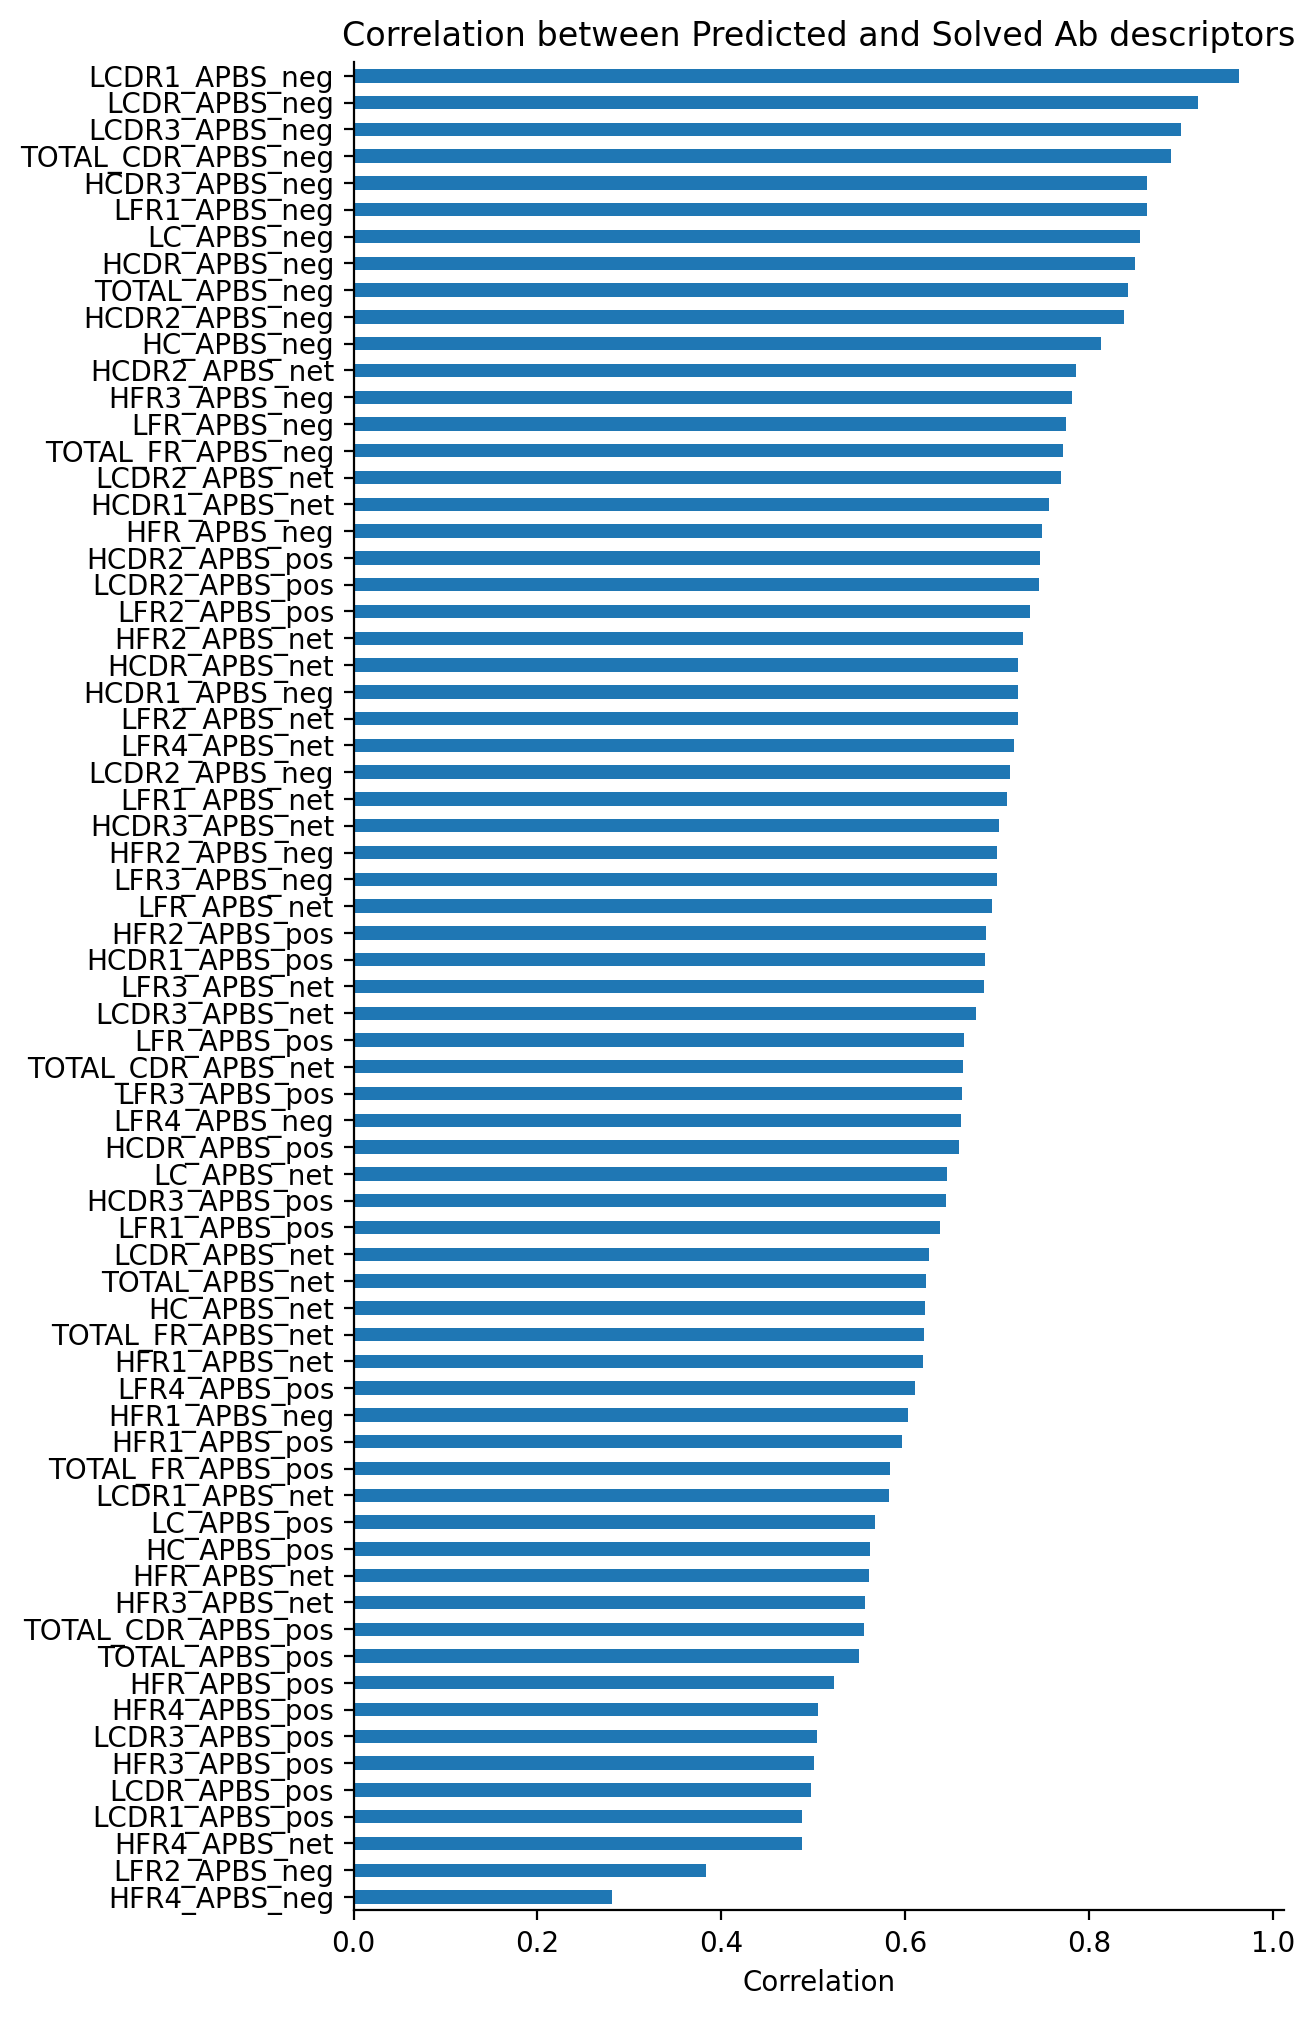

In [22]:
ax =subset_df[common_cols].corrwith(previous_subset_df[common_cols]).sort_values().plot(kind = 'barh', figsize = (6, 12))
ax.set(xlabel = 'Correlation', title='Correlation between Predicted and Solved Ab descriptors')
sns.despine()

In [23]:
len(previous_subset_df)
len(subset_df)

50

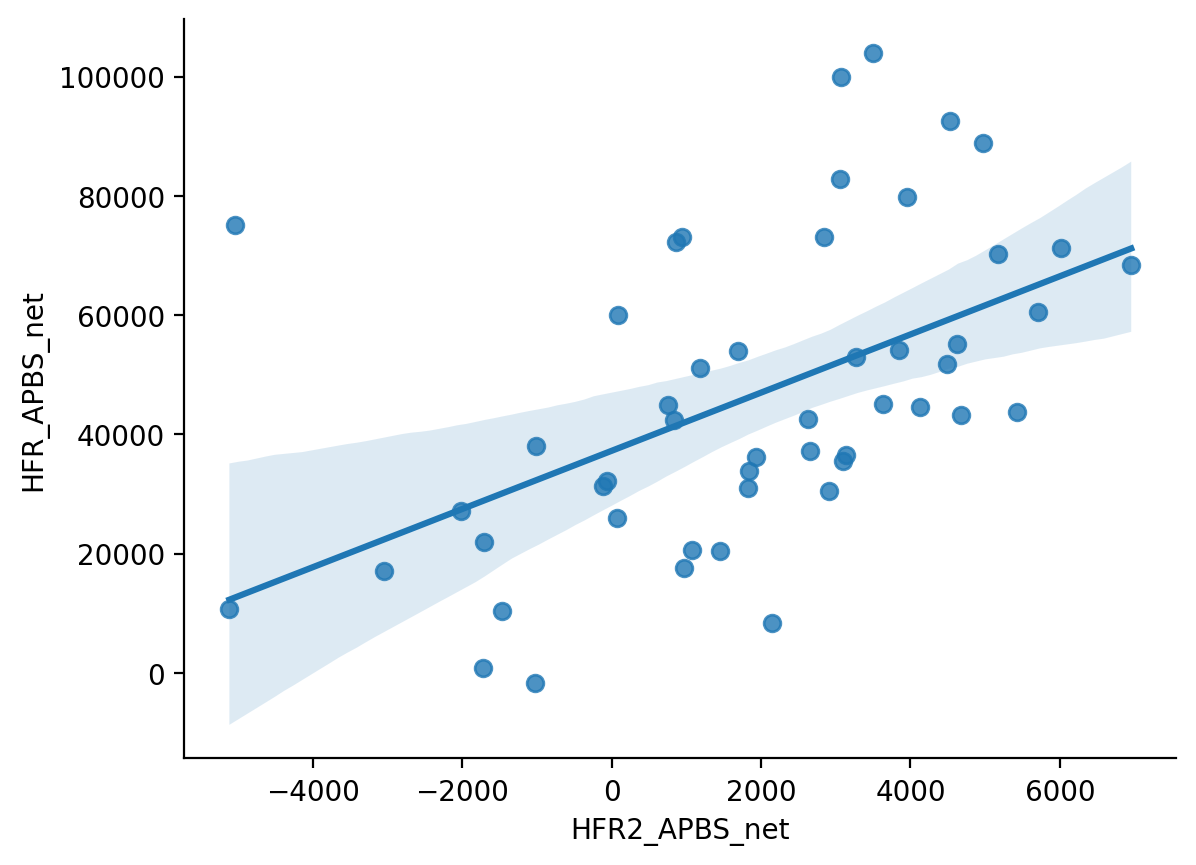

In [24]:
sns.regplot(x=previous_subset_df['HFR2_APBS_net'], y=subset_df['HFR_APBS_net']) 
sns.despine()

### Look at the subset correlation with heparin. 

In [25]:
def plot_correlogram(d, cmap='RdBu', method = 'pearson'):

    # Compute the correlation matrix
    corr = d.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    #cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [26]:
heparin = previous_subset_df['Heparin']
try: 
    subset_df.insert(0, 'Heparin', heparin.values)
except: 
    pass

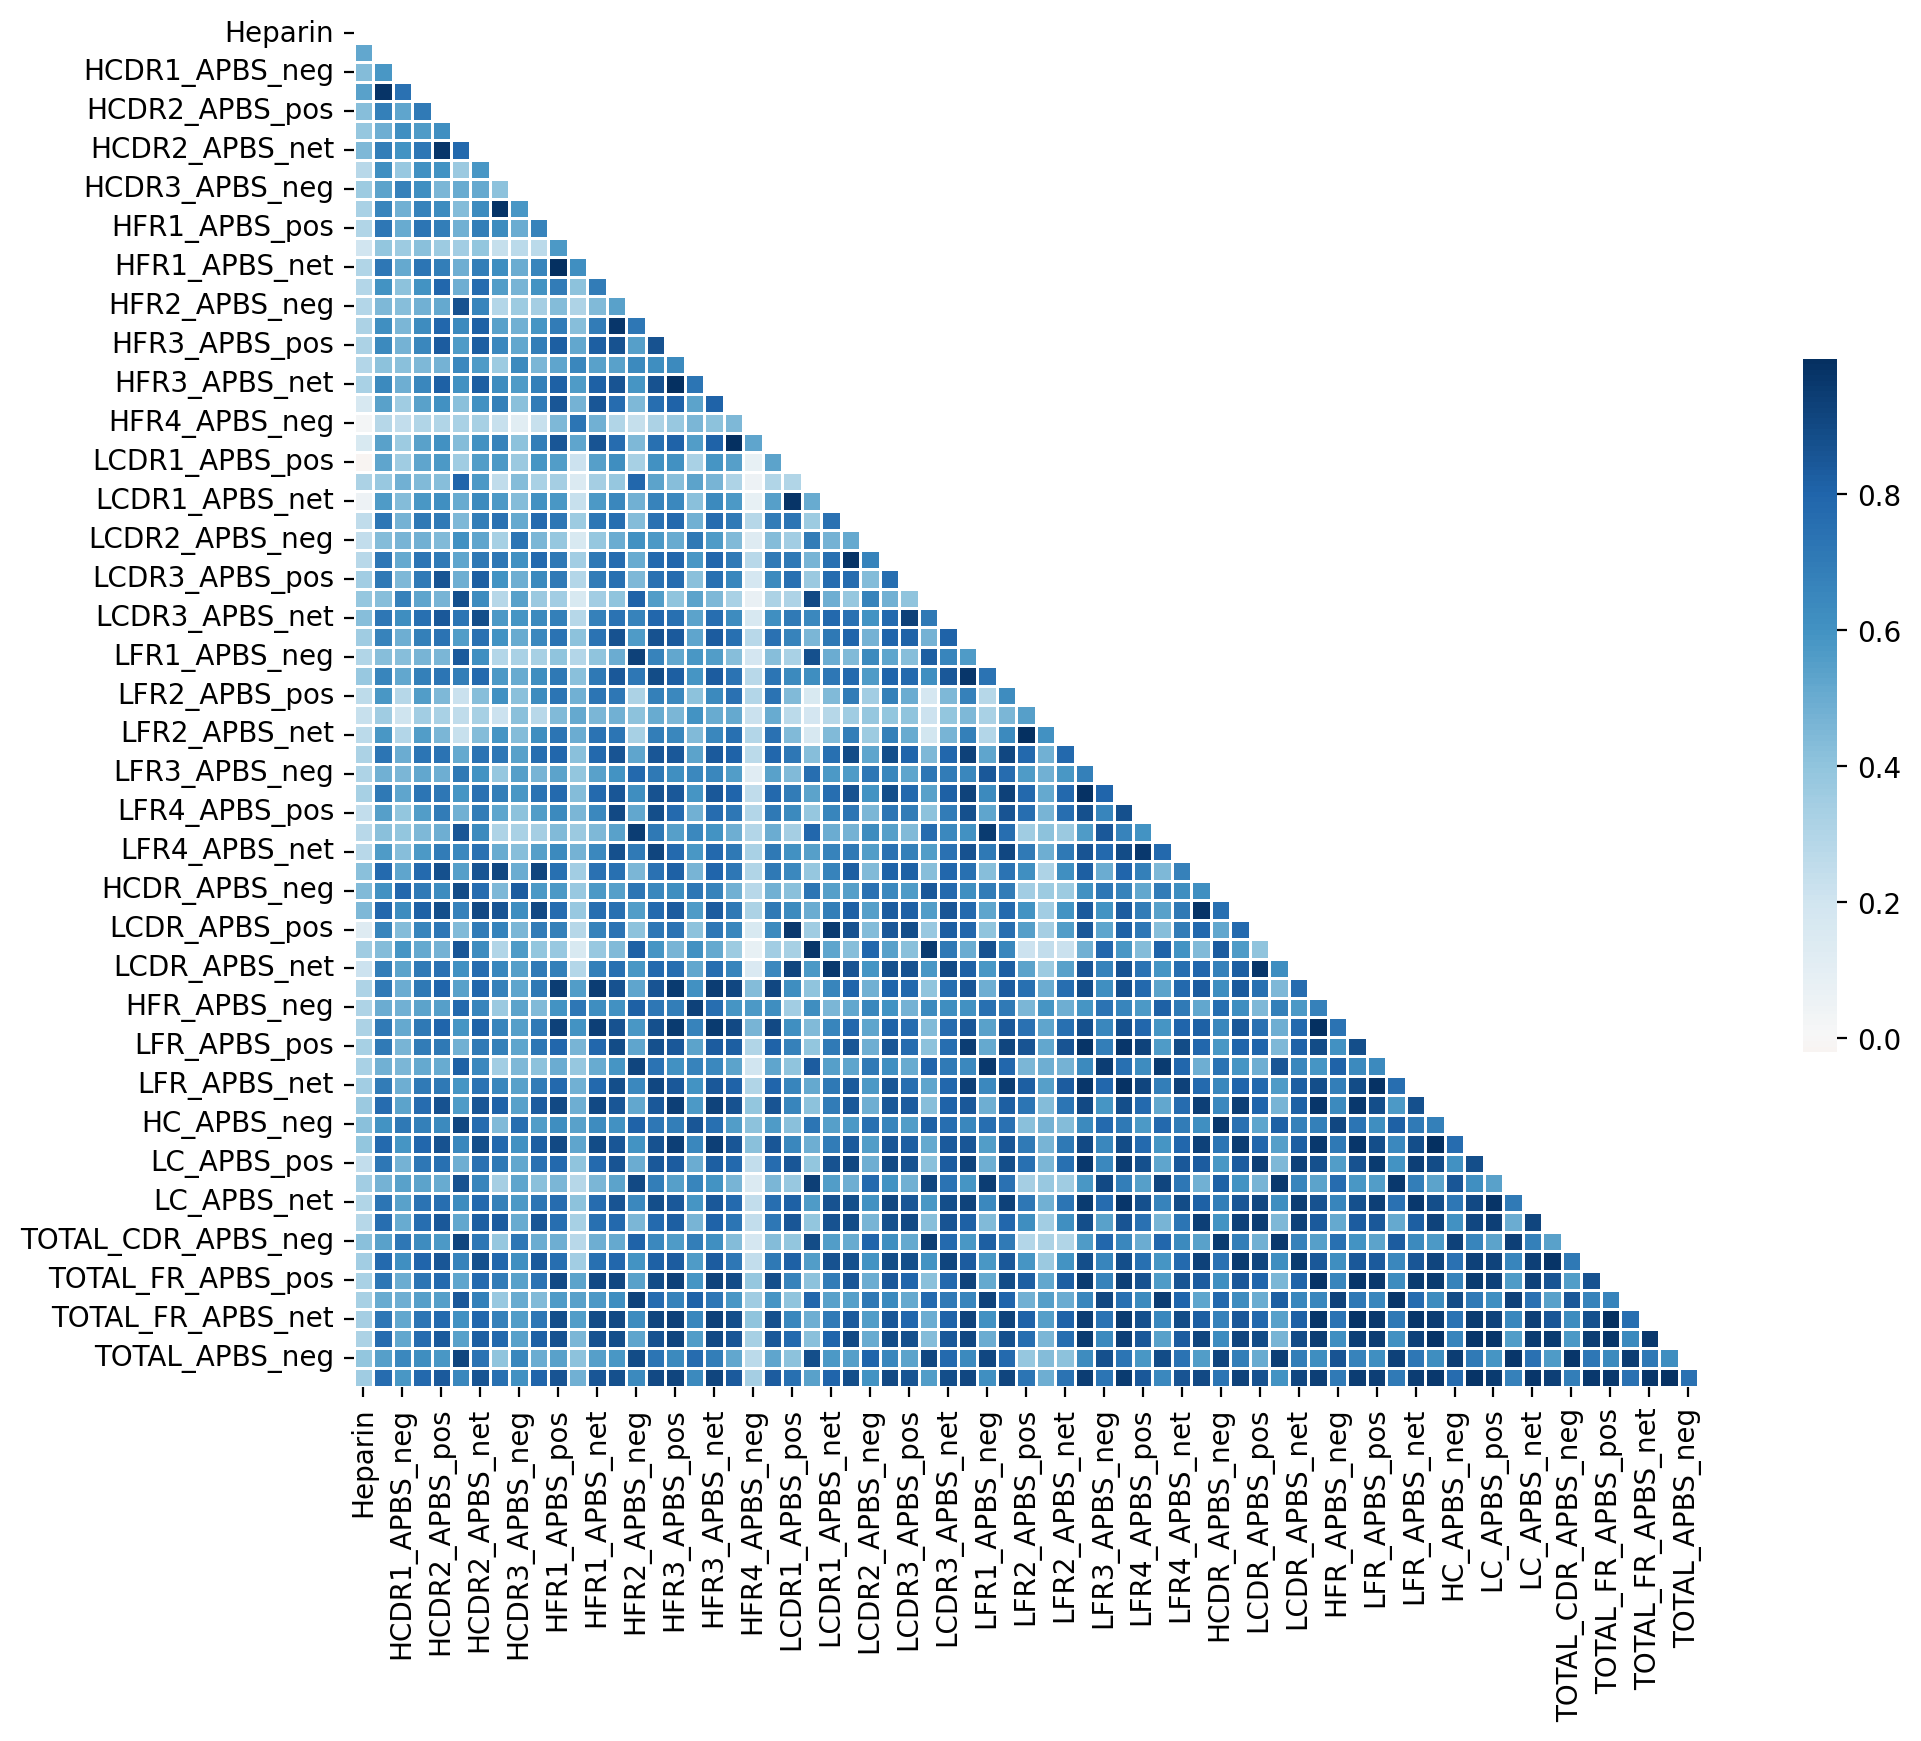

In [27]:
corr = subset_df.corr()

plot_correlogram(subset_df)

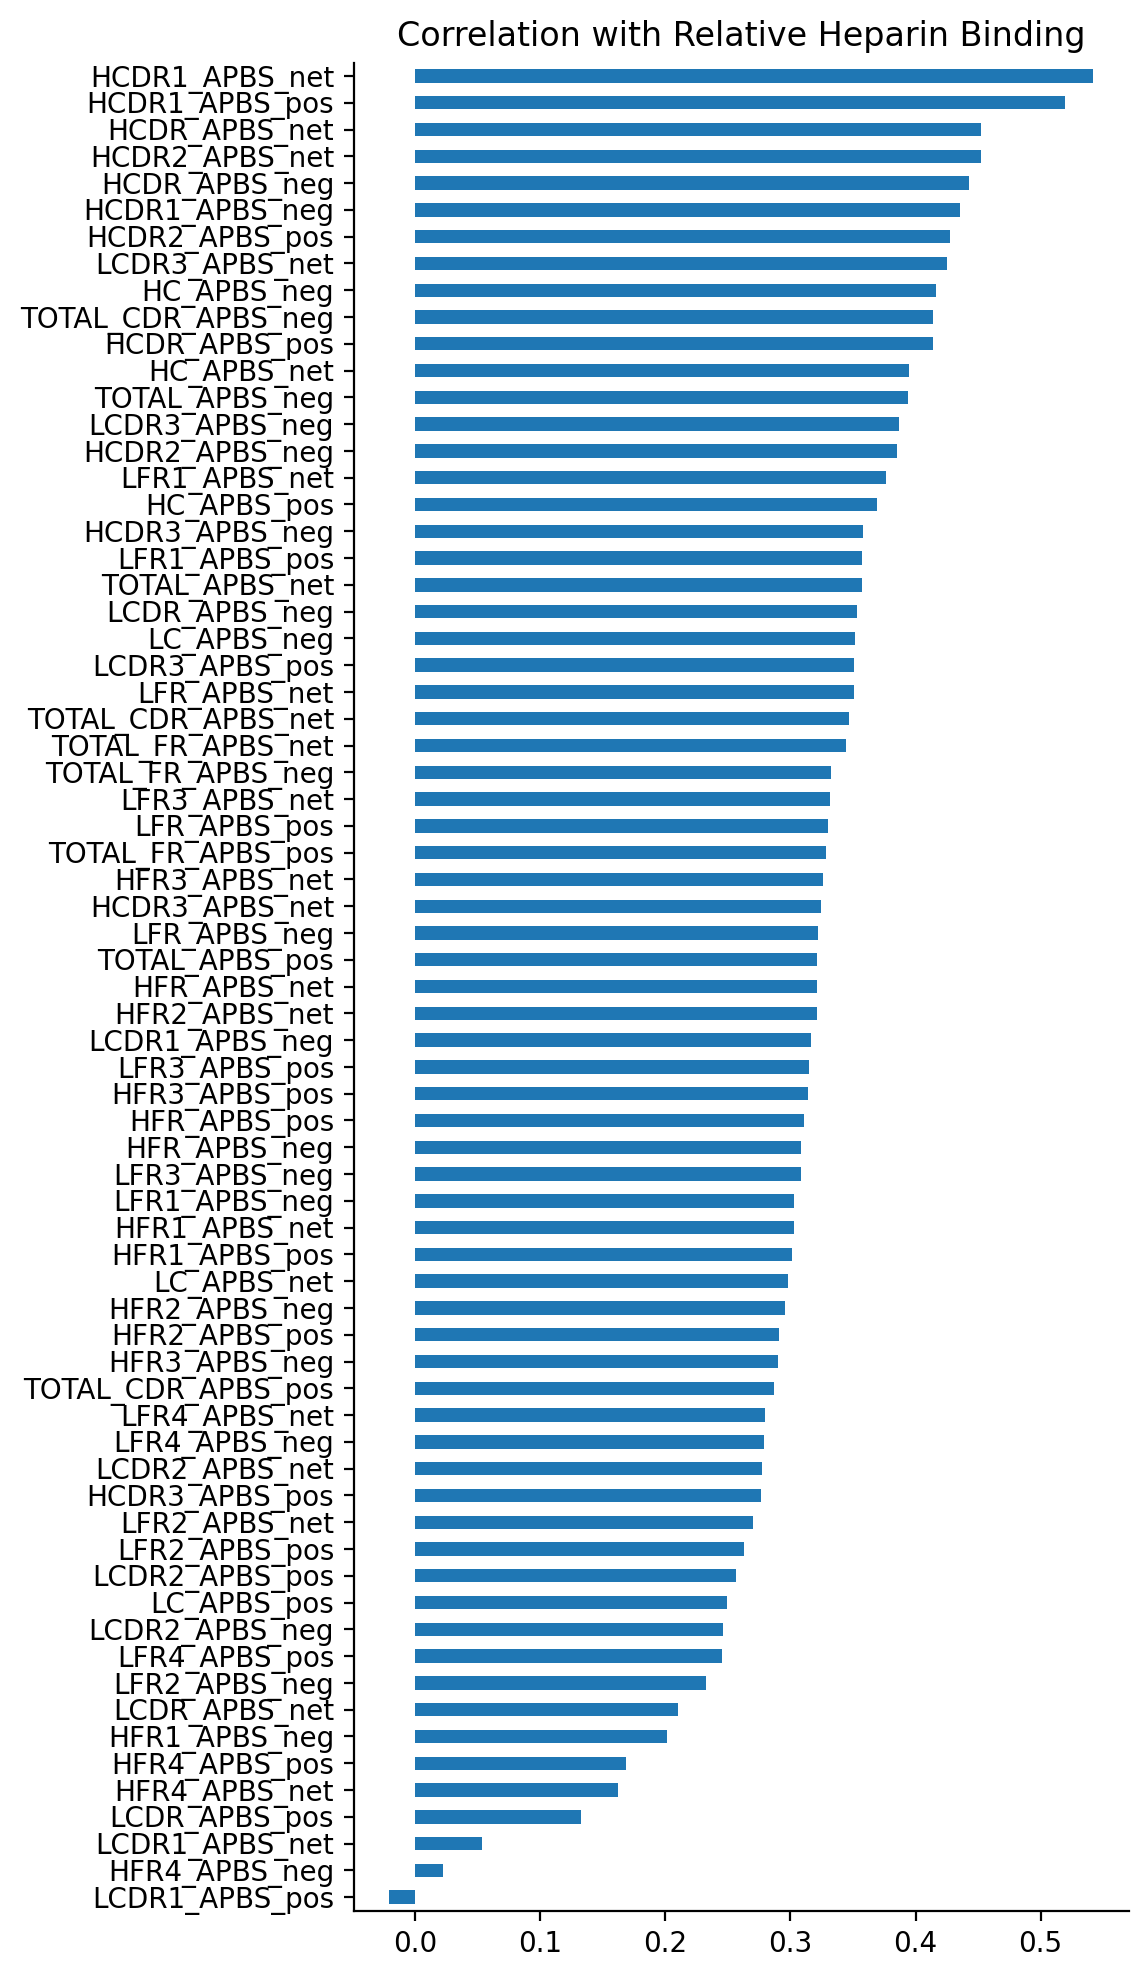

In [28]:
heparin_corr = corr.loc['Heparin'].sort_values()
ax = heparin_corr.drop('Heparin').plot(kind = 'barh', figsize = (5, 12))
ax.set(title = 'Correlation with Relative Heparin Binding')
sns.despine()

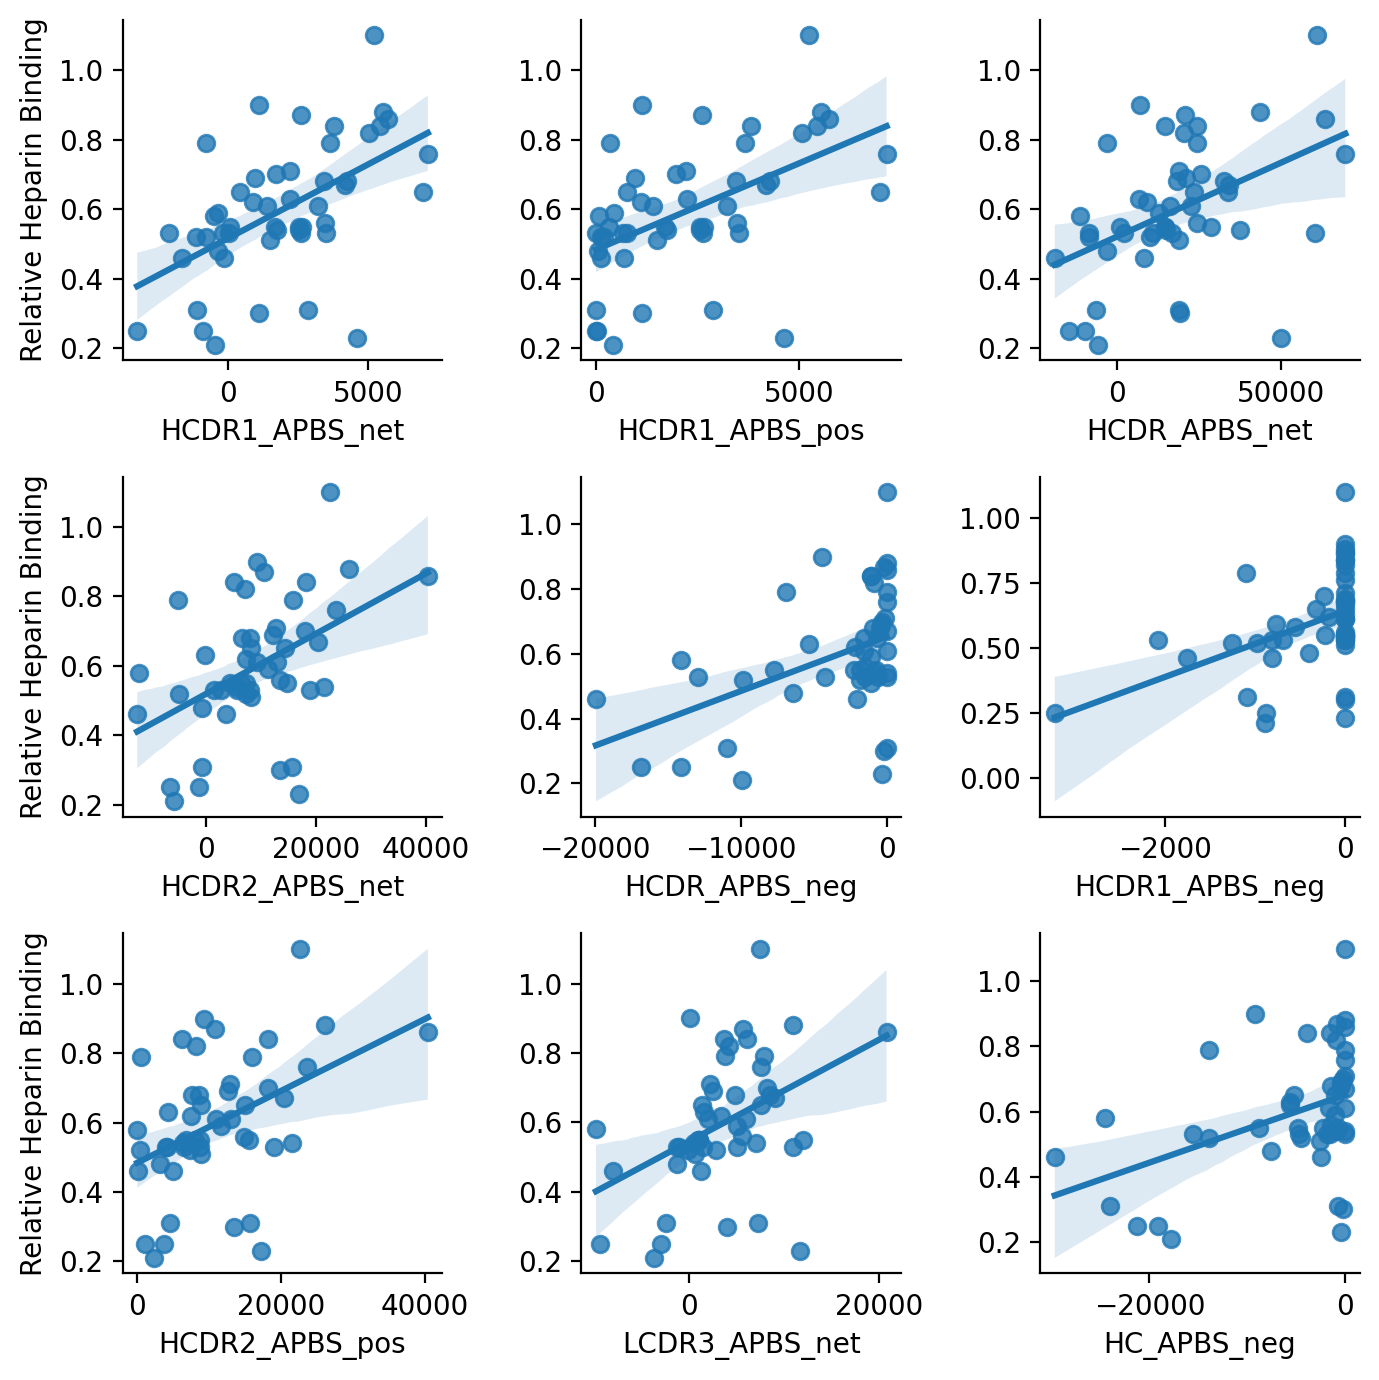

In [29]:
# plot the 9 most correlated in magnitude 
abs_heparin_corr = np.abs(heparin_corr).sort_values(ascending = False).iloc[1:]

fig, axes = plt.subplots(3,3, figsize = (7,7))
axes = np.ravel(axes)
for i in range(9):
    col = abs_heparin_corr.index[i]
    sns.regplot(x= subset_df[col].values, y= heparin.values, ax = axes[i])
    axes[i].set(xlabel = col)
    if i%3==0: 
        axes[i].set(ylabel = 'Relative Heparin Binding')
sns.despine()
plt.tight_layout()



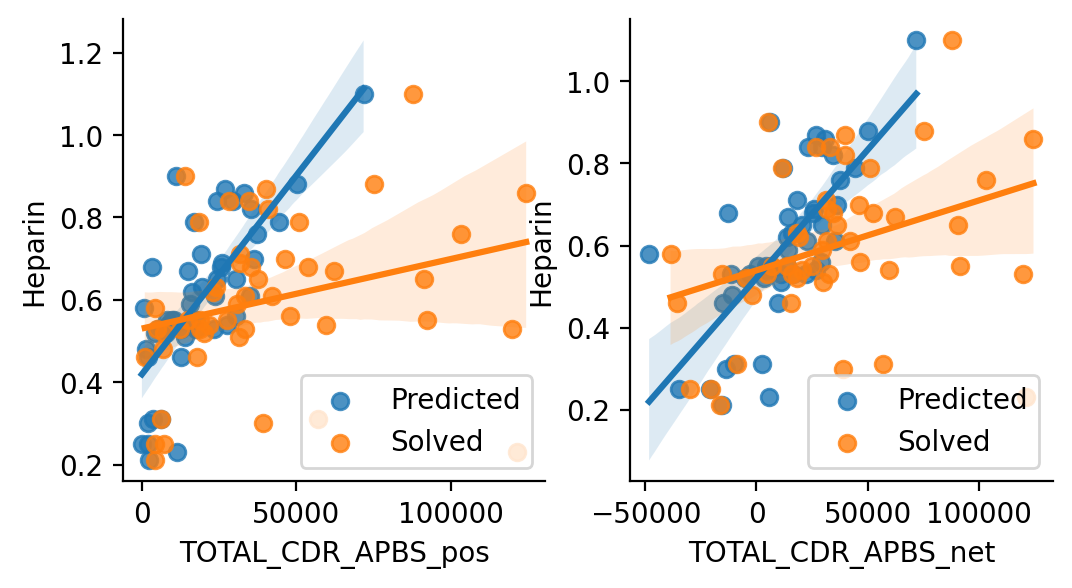

In [30]:
fig, axes = plt.subplots(1,2, figsize = (6,3))
x1 = previous_subset_df['TOTAL_CDR_APBS_pos'].values
x2 = subset_df['TOTAL_CDR_APBS_pos'].values
y = heparin

ax =sns.regplot(x= x1, y = y, label ='Predicted', ax =axes[0])
sns.regplot(x= x2, y = y, label = 'Solved', ax = ax)
ax.set(xlabel='TOTAL_CDR_APBS_pos')
ax.legend()


x1 = previous_subset_df['TOTAL_CDR_APBS_net'].values
x2 = subset_df['TOTAL_CDR_APBS_net'].values
y = heparin

ax =sns.regplot(x= x1, y = y, label ='Predicted', ax =axes[1])
sns.regplot(x= x2, y = y, label = 'Solved', ax = ax)
ax.set(xlabel='TOTAL_CDR_APBS_net')
ax.legend()
sns.despine()

sns.despine()

In [31]:
max_pos_ab = subset_df.index[subset_df['TOTAL_CDR_APBS_pos'].argmax()]
print(max_pos_ab, subset_df['TOTAL_CDR_APBS_pos'].loc[max_pos_ab])
print(max_pos_ab, previous_subset_df['TOTAL_CDR_APBS_pos'].loc[max_pos_ab])

bapineuzumab 124517.75619815999
bapineuzumab 33057.3282532878


In [32]:
pd.DataFrame((previous_subset_df[common_cols]<subset_df[common_cols]).mean()).T

,HCDR1_APBS_pos,LFR_APBS_pos,LC_APBS_neg,HFR3_APBS_neg,LCDR2_APBS_neg,LFR4_APBS_neg,LFR_APBS_neg,TOTAL_CDR_APBS_neg,LFR2_APBS_pos,HFR4_APBS_neg,LFR2_APBS_net,HFR_APBS_neg,HFR2_APBS_neg,LCDR2_APBS_pos,HCDR1_APBS_net,LCDR3_APBS_neg,HFR1_APBS_net,LCDR1_APBS_net,LFR4_APBS_pos,HCDR3_APBS_neg,LFR3_APBS_net,TOTAL_FR_APBS_net,LFR3_APBS_pos,HFR4_APBS_pos,HFR2_APBS_net,HCDR_APBS_pos,HCDR2_APBS_net,LFR2_APBS_neg,HFR2_APBS_pos,HFR_APBS_pos,TOTAL_FR_APBS_pos,HFR3_APBS_pos,HFR1_APBS_neg,LFR3_APBS_neg,TOTAL_CDR_APBS_net,LCDR1_APBS_neg,TOTAL_APBS_net,LCDR2_APBS_net,LFR1_APBS_pos,HFR_APBS_net,LCDR3_APBS_pos,LCDR_APBS_pos,HC_APBS_pos,HCDR2_APBS_pos,HC_APBS_net,LCDR_APBS_net,HFR3_APBS_net,HCDR_APBS_net,LCDR_APBS_neg,TOTAL_CDR_APBS_pos,HFR4_APBS_net,TOTAL_APBS_pos,HCDR3_APBS_net,LFR4_APBS_net,HFR1_APBS_pos,LFR_APBS_net,LCDR3_APBS_net,TOTAL_APBS_neg,LC_APBS_net,HC_APBS_neg,LFR1_APBS_neg,HCDR3_APBS_pos,LCDR1_APBS_pos,HCDR1_APBS_neg,LFR1_APBS_net,HCDR_APBS_neg,LC_APBS_pos,HCDR2_APBS_neg,TOTAL_FR_APBS_neg
0,0.74,1.0,0.74,0.66,0.32,0.88,0.8,0.5,0.94,0.94,0.92,0.84,0.5,0.88,0.72,0.46,1.0,0.88,1.0,0.38,0.88,1.0,0.98,0.98,0.76,0.96,0.9,0.42,0.82,1.0,1.0,1.0,0.8,0.54,0.9,0.46,0.98,0.84,0.98,1.0,0.8,0.94,1.0,0.94,0.96,0.86,0.96,0.92,0.48,0.96,0.98,1.0,0.82,1.0,1.0,0.94,0.76,0.76,0.92,0.72,0.88,0.9,0.92,0.24,0.94,0.5,0.98,0.54,0.84


#### Function for extracting PDB

In [33]:
antibodies = [f for f in ls(fab_path) if f.name.endswith('.pdb')]
antibodies.sort()

In [34]:
from Bio.PDB import PDBParser
from Bio.PDB.PDBIO import PDBIO

def extract_fv_from_pdb(pdb, output_pdb=None, scheme='kabat'): 
    """extracts the fv region from pdb and saves pdb. 
    The PDB has VH then VL. 
    Args:
        pdb (str|path): path to pdb file with ab
        output_pdb (str|path): path to output
    Returns: 
        Path: to new object
    """
    
    seqs = extract_sequence_from_pdb(pdb)
    
    fv_sequences = {}
    fv_chains = {}

    for name, seq in seqs.items(): 
        chain = Chain(seq, scheme = scheme)
        fv_sequences[name] = chain.seq
        if chain.is_heavy_chain(): 
            fv_chains[name]="H"
        else: 
            fv_chains[name]="L"

    pdb_name = Path(pdb).name.split('.')[0]
    parser = PDBParser()
    struct= parser.get_structure(pdb_name,pdb)

    # now get the regions of interest for each chain. 
    for chain  in struct.get_chains(): 
        chain_id = chain.id

        new_child_dict = {}
        new_child_list = []
        
        # find the locations of the fv region in the PDB chain object
        fv = fv_sequences[chain_id]
        seq = seqs[chain_id]
        start = seq.find(fv) 
        end = start+ len(fv)
        
        # iterate through the PDB chain object and add the residues of interest.
        residue_num = 1
        num = 0
        for residue_id, residue in chain.child_dict.items(): 
            
            if (num>= start) & (num <end):
                new_id = (residue_id[0], residue_num, residue_id[2] )
                new_residue = residue.copy()
                new_residue.id = new_id
                
                new_child_dict[new_id] = new_residue
                new_child_list.append(new_residue)
                residue_num+=1
            
            num+=1

        # update the chains
        chain.child_dict = new_child_dict
        chain.child_list = new_child_list
        chain.id=fv_chains[chain_id]

    #update the order of chains.
    model = struct.child_dict[0]
    model.child_list = [model.child_dict['H'], model.child_dict['L']]
    
    # save the pdb
    if not output_pdb: 
        output_pdb = Path(pdb).with_suffix('.fv_only.pdb')
    pdb_io = PDBIO()
    pdb_io.set_structure(struct)
    pdb_io.save(str(output_pdb))

    return output_pdb

### Conclusion: 

For this "experiment", I got vastly different results. However, initially I used ABodyBuilder2 to model the Fv region only. In this case I included much more of the protein. This led to very different results. 
Above, I wrote code to select only regions of the antibody of interest. I will redo the calculations in another notebook. 